In [14]:
import numpy  as np
import pandas as pd

print('numpy  version - ' , np.__version__) 
print('pandas version - ' , pd.__version__) 

from   io import StringIO
import missingno as msno
# ml
import sklearn
from   sklearn.datasets import load_iris, load_breast_cancer

print('sklearn version - ' , sklearn.__version__)

from sklearn.model_selection import train_test_split, KFold , StratifiedKFold , cross_val_score, cross_validate, GridSearchCV 
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier         
from sklearn.linear_model    import LogisticRegression , LinearRegression


from sklearn.metrics         import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, make_scorer , precision_recall_curve 
from sklearn.impute          import SimpleImputer

from sklearn.preprocessing   import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

numpy  version -  1.22.1
pandas version -  1.4.0
sklearn version -  1.0.2


## 고등학교 진학률 데이터를 활용하여 속성이 비슷한 중학교끼리 클러스터
- 데이터 인코딩, 지도시각화(위도, 경도, folium)

### 진행절차
#### 01. 데이터 전처리 - (지역, 코드 , 유형, 주야)
#### 02. 군집모형생성 - 분석에 사용할 피처는 과학고, 외고국제고, 자사고 진학률
#### 03. 표준화
#### 04. 모형 객체 생성
#### 05. 모형 학습
#### 06. 예측
#### 07. 예측 결과를 데이터 프레임에 추가
#### 08. 클러스터 값으로 그룹화, 그룹별 내용 출력
#### 09. 지도 그래프 시각화

In [18]:
school = pd.read_excel('2022-01-13~19/data/middle_shcool_graduates_report.xlsx')
school_frm = school.copy()
school_frm.head(1)

,Unnamed: 0,지역,학교명,코드,유형,주야,남학생수,여학생수,일반고,특성화고,...,외고_국제고,예고_체고,마이스터고,자사고,자공고,기타진학,취업,미상,위도,경도
0,0,성북구,서울대학교사범대학부설중학교,3,국립,주간,277,0,0.585,0.148,...,0.007,0.0,0.011,0.227,0.0,0.004,0,0.0,37.594942,127.038909


In [19]:
school_frm.info()
school_frm.drop(['Unnamed: 0'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  415 non-null    int64  
 1   지역          415 non-null    object 
 2   학교명         415 non-null    object 
 3   코드          415 non-null    int64  
 4   유형          415 non-null    object 
 5   주야          415 non-null    object 
 6   남학생수        415 non-null    int64  
 7   여학생수        415 non-null    int64  
 8   일반고         415 non-null    float64
 9   특성화고        415 non-null    float64
 10  과학고         415 non-null    float64
 11  외고_국제고      415 non-null    float64
 12  예고_체고       415 non-null    float64
 13  마이스터고       415 non-null    float64
 14  자사고         415 non-null    float64
 15  자공고         415 non-null    float64
 16  기타진학        415 non-null    float64
 17  취업          415 non-null    int64  
 18  미상          415 non-null    float64
 19  위도          415 non-null    f

In [20]:
print ('01. 데이터 전처리 - (지역, 코드 , 유형, 주야)') 
label_encoder = LabelEncoder()
school_frm['지역'] = label_encoder.fit_transform(school_frm['지역'])
school_frm['코드'] = label_encoder.fit_transform(school_frm['코드'])
school_frm['유형'] = label_encoder.fit_transform(school_frm['유형'])
school_frm['주야'] = label_encoder.fit_transform(school_frm['주야'])

01. 데이터 전처리 - (지역, 코드 , 유형, 주야)


In [21]:
def feature_scaling(method='None' , input_data = None) :
    if method == 'standard' :
        return StandardScaler().fit_transform(input_data)
    if method == 'minmax' :
        return MinMaxScaler().fit_transform(input_data)

In [22]:
print('02. 군집모형생성 - 분석에 사용할 피처는 과학고, 외고국제고, 자사고 진학률')

school_data = school_frm[['과학고', '외고_국제고', '자사고']]
school_data

02. 군집모형생성 - 분석에 사용할 피처는 과학고, 외고국제고, 자사고 진학률


,과학고,외고_국제고,자사고
0,0.018,0.007,0.227
1,0.000,0.035,0.043
2,0.009,0.012,0.090
3,0.013,0.013,0.065
4,0.007,0.010,0.282
...,...,...,...
410,0.000,0.000,0.000
411,0.000,0.000,0.000
412,0.000,0.000,0.000
413,0.000,0.000,0.000


In [23]:
print('03. 표준화')
school_scaler = feature_scaling(method='standard', input_data = school_data)
school_scaler

03. 표준화


array([[ 2.02375287, -0.57972902,  1.84751715],
       [-0.65047921,  1.84782097, -0.48039958],
       [ 0.68663683, -0.14623795,  0.11423133],
       ...,
       [-0.65047921, -1.18661652, -1.0244236 ],
       [-0.65047921, -1.18661652, -1.0244236 ],
       [-0.65047921,  0.89414062, -0.89790638]])

In [24]:
print('04. 모형 객체 생성')
print('군집모형 - ')
kmeans = KMeans(n_clusters = 3)

print('05. 모형 학습')
kmeans.fit(school_scaler)

print('06. 모형 예측')
print('군집예측 - ')
print(kmeans.labels_)

04. 모형 객체 생성
군집모형 - 
05. 모형 학습
06. 모형 예측
군집예측 - 
[2 0 0 0 2 1 2 2 2 0 2 0 0 0 2 0 2 1 2 2 1 2 0 0 0 2 2 2 1 1 2 2 0 0 1 1 0
 0 0 2 2 2 2 0 1 2 1 1 0 0 0 0 1 2 1 1 1 2 1 1 0 1 1 1 2 1 1 1 0 0 1 0 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 2 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 2
 1 2 2 0 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0
 1 0 2 2 1 1 1 1 1 2 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 2 2 1 1 1 1 0 2 0 0 2 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0
 0 1 0 0 0 0 2 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1
 1 1 0 2 1 0 2 1 0 1 1 1 0 1 1 1 2 0 0 2 1 1 1 1 1 1 1 1 2 1 1 0 0 1 2 0 1
 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 2 0 0 1 0 0 1 0 0 0 0 1 1
 1 0 1 0 1 0 1 1 1 1 0 1 1 2 1 1 1 1 0 2 1 1 1 1 0 2 2 2 1 0 0 0 0 2 1 0 2
 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0]


In [25]:
print('07. 예측 결과를 데이터 프레임에 추가')
school_frm['cid'] = kmeans.labels_
school_frm

07. 예측 결과를 데이터 프레임에 추가


,지역,학교명,코드,유형,주야,남학생수,여학생수,일반고,특성화고,과학고,...,예고_체고,마이스터고,자사고,자공고,기타진학,취업,미상,위도,경도,cid
0,16,서울대학교사범대학부설중학교,0,1,0,277,0,0.585,0.148,0.018,...,0.000,0.011,0.227,0.000,0.004,0,0.000,37.594942,127.038909,2
1,22,서울대학교사범대학부설여자중학교,0,1,0,0,256,0.680,0.199,0.000,...,0.008,0.000,0.043,0.004,0.031,0,0.000,37.577473,127.003857,0
2,0,개원중학교,0,0,0,170,152,0.817,0.047,0.009,...,0.003,0.006,0.090,0.003,0.009,0,0.003,37.491637,127.071744,0
3,0,개포중학교,0,0,0,83,72,0.755,0.097,0.013,...,0.019,0.019,0.065,0.000,0.019,0,0.000,37.480439,127.062201,0
4,14,경원중학교,0,0,0,199,212,0.669,0.017,0.007,...,0.005,0.000,0.282,0.000,0.010,0,0.000,37.510750,127.008900,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,0,국립국악중학교,2,1,0,9,91,0.060,0.000,0.000,...,0.940,0.000,0.000,0.000,0.000,0,0.000,37.476381,127.051355,1
411,7,국립전통예술중학교,2,1,0,14,42,0.107,0.000,0.000,...,0.875,0.000,0.000,0.000,0.000,0,0.018,37.446354,126.906424,1
412,5,선화예술학교,2,2,0,33,241,0.102,0.000,0.000,...,0.861,0.000,0.000,0.000,0.000,0,0.036,37.549642,127.087737,1
413,23,예원학교,2,2,0,31,258,0.170,0.000,0.000,...,0.751,0.000,0.000,0.000,0.048,0,0.031,37.566951,126.971553,1


In [26]:
print('08. 클러스터 값으로 그룹화, 그룹별 내용 출력')
school_pca = PCA(n_components = 2) 

school_pca_trans  = school_pca.fit_transform(school_scaler)
school_pca_trans

08. 클러스터 값으로 그룹화, 그룹별 내용 출력


array([[ 1.98514011e+00,  1.96554782e+00],
       [ 3.30622168e-01, -1.97915681e+00],
       [ 3.97483595e-01,  4.12711201e-01],
       [ 6.11474120e-01,  4.19378497e-01],
       [ 1.56419417e+00,  1.45698662e+00],
       [ 1.19980926e-01,  7.65527454e-01],
       [ 3.85514451e+00,  2.36590364e-01],
       [ 2.97338343e+00,  2.73671310e+00],
       [ 2.12804948e+00, -2.11404855e-01],
       [ 1.06429030e+00, -7.83475170e-01],
       [ 3.37964582e+00,  1.12887411e+00],
       [ 9.94614098e-01, -4.19012652e-01],
       [ 1.72248532e+00, -8.11332730e-01],
       [-3.18391200e-01, -1.05949244e+00],
       [ 1.67888367e+00,  1.19241711e+00],
       [ 5.59922334e-01, -1.07467159e-01],
       [ 8.93700427e-01,  9.61047253e-01],
       [-5.06112251e-01, -2.68020367e-01],
       [ 1.86527312e+00,  8.35177428e-01],
       [ 2.87810660e+00,  6.29024250e-01],
       [-1.24174406e-01, -1.37769890e-03],
       [ 1.65493296e+00,  1.02947843e+00],
       [-4.14588524e-01, -8.09859834e-01],
       [ 3.

In [27]:
school_frm['std_pca_x'] = school_pca_trans[ : , 0]
school_frm['std_pca_y'] = school_pca_trans[ : , 1]
school_frm

,지역,학교명,코드,유형,주야,남학생수,여학생수,일반고,특성화고,과학고,...,자사고,자공고,기타진학,취업,미상,위도,경도,cid,std_pca_x,std_pca_y
0,16,서울대학교사범대학부설중학교,0,1,0,277,0,0.585,0.148,0.018,...,0.227,0.000,0.004,0,0.000,37.594942,127.038909,2,1.985140,1.965548
1,22,서울대학교사범대학부설여자중학교,0,1,0,0,256,0.680,0.199,0.000,...,0.043,0.004,0.031,0,0.000,37.577473,127.003857,0,0.330622,-1.979157
2,0,개원중학교,0,0,0,170,152,0.817,0.047,0.009,...,0.090,0.003,0.009,0,0.003,37.491637,127.071744,0,0.397484,0.412711
3,0,개포중학교,0,0,0,83,72,0.755,0.097,0.013,...,0.065,0.000,0.019,0,0.000,37.480439,127.062201,0,0.611474,0.419378
4,14,경원중학교,0,0,0,199,212,0.669,0.017,0.007,...,0.282,0.000,0.010,0,0.000,37.510750,127.008900,2,1.564194,1.456987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,0,국립국악중학교,2,1,0,9,91,0.060,0.000,0.000,...,0.000,0.000,0.000,0,0.000,37.476381,127.051355,1,-1.637934,0.342427
411,7,국립전통예술중학교,2,1,0,14,42,0.107,0.000,0.000,...,0.000,0.000,0.000,0,0.018,37.446354,126.906424,1,-1.637934,0.342427
412,5,선화예술학교,2,2,0,33,241,0.102,0.000,0.000,...,0.000,0.000,0.000,0,0.036,37.549642,127.087737,1,-1.637934,0.342427
413,23,예원학교,2,2,0,31,258,0.170,0.000,0.000,...,0.000,0.000,0.048,0,0.031,37.566951,126.971553,1,-1.637934,0.342427


In [28]:
school_kmeans = KMeans(n_clusters=3)
school_kmeans.fit(school_frm.iloc[ : , -2 : ])

KMeans(n_clusters=3)

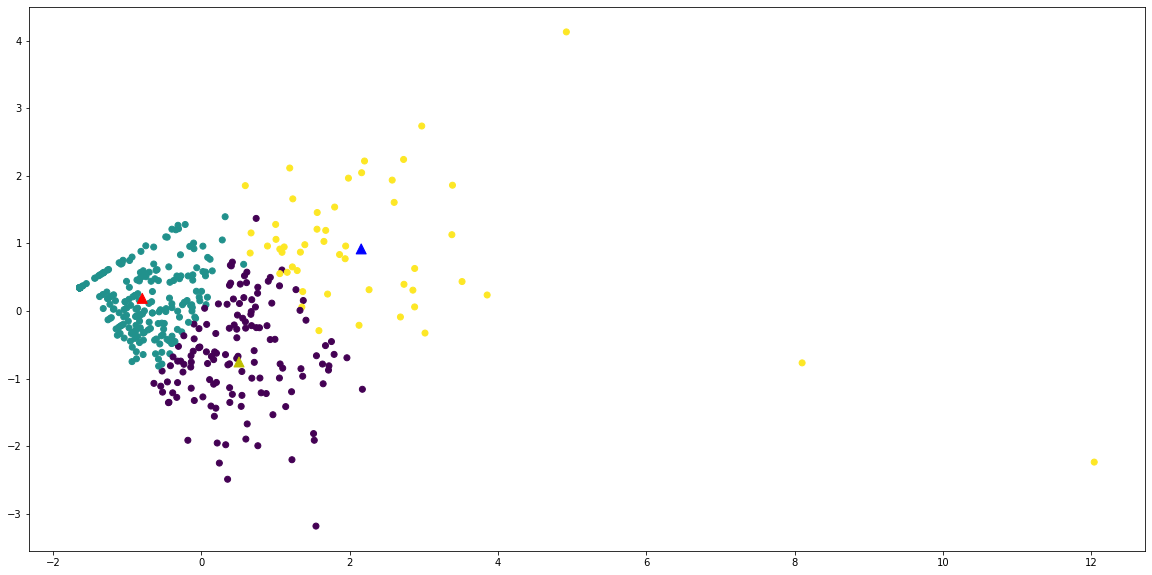

In [29]:
plt.figure(figsize=(20,10))

plt.scatter(school_frm['std_pca_x'] , 
            school_frm['std_pca_y'] , 
            c = school_frm['cid'])

plt.scatter(school_kmeans.cluster_centers_[ : , 0],
            school_kmeans.cluster_centers_[ : , 1],
            marker = '^', 
            c = ['r', 'b', 'y'], 
            s = 100)

plt.show()
plt.close()

In [32]:
import folium
school_frm['cid'].unique()

array([2, 0, 1])

In [33]:
print("09. 지도 그래프 시각화")
school_map = folium.Map(location=[37.56639984255284, 126.97796323615714],
                        zoom_start = 12,
                        tiles = 'cartodb positron') 

def cid_color(x):
    if x == 0:
            return folium.Icon(color = 'darkpurple')
    if x == 1:
            return folium.Icon(color = 'orange')
    if x == 2:
            return folium.Icon(color = 'pink')
            

for name, lat, lng, cid in zip(school_frm['학교명'], school_frm['위도'], school_frm['경도'], school_frm['cid']):
    folium.Marker(
        [lat, lng],
        popup=name,
        icon = cid_color(cid)
    ).add_to(school_map)
    
school_map

09. 지도 그래프 시각화


In [34]:
개원,개포 핑크

SyntaxError: invalid syntax (Temp/ipykernel_18860/890308239.py, line 1)

In [35]:
서울대학교 사범대학 부설중학교 주황

SyntaxError: invalid syntax (Temp/ipykernel_18860/3699815427.py, line 1)